Here, we will perform text classification using a variant of BERT called DistilBERT.
* It achieves comparable performance to BERT, while being significantly smaller and more efficient.
* This enables us to train a classifier in a few minutes.

If you want to train a larger BERT model you can simply change the checkpoint of the pretrained model. 
*A checkpoint corresponds to the set of weights that are loaded into a given transformer architecture.*

We will use 3 core libraries from the HuggingFace ecosystem: Datasets, Tokenizers, and Transformer.

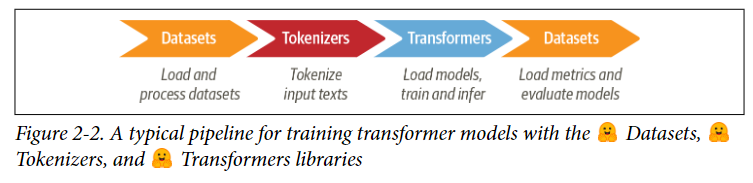



# The Dataset

**Dataset:**
- We’ll use a  dataset from an article that explored how emotions are represented in English Twitter messages.
- Unlike most sentiment analysis datasets that involve just “positive” and “negative” polarities, this dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise.

**Task:** Given a tweet, our task will be to train a model that can classify it into one of these emotions.

## A First Look at Hugging Face Datasets

In [1]:
!pip uninstall datasets -y
!pip install datasets


Found existing installation: datasets 3.2.0
Uninstalling datasets-3.2.0:
  Successfully uninstalled datasets-3.2.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.0 MB/s eta 0:00:00


In [2]:
# load emotions dataset

from datasets import load_dataset

emotions = load_dataset("emotion")

# let's look inside emotions object
emotions

README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
# accessing train split of the dataset
train_ds = emotions["train"]
train_ds # returns an instance of the Dataset class

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

Dataset class behaves like an ordinary Python array or list

In [4]:
# let's query its length
len(train_ds)

16000

In [5]:
# Access a single item by its index
print(train_ds[0]) # returns a dictionary

# A single row is represented as a dictionary, where the keys correspond to the column names:
print(train_ds.column_names)

# and the values are the tweet and the emotion.

{'text': 'i didnt feel humiliated', 'label': 0}
['text', 'label']


This reflects the fact that  Datasets is based on Apache Arrow, which defines a typed columnar format that is more memory efficient than native Python. 

**1. What is Apache Arrow?**

- **Apache Arrow** is a framework for working with data in a columnar, in-memory format.
- It is specifically designed to be **efficient** in terms of memory usage and performance, making it ideal for modern data processing needs.

Key features of Arrow:
- **Columnar Format**: Data is stored column by column rather than row by row.
- **Typed Data**: Each column has a specific data type (e.g., integers, strings, floats).
- **In-Memory Optimization**: Data is stored in a way that minimizes memory overhead and is ready for direct access by high-performance applications.

---

**2. How Does Hugging Face's `Datasets` Library Use Apache Arrow?**

The Hugging Face `datasets` library uses Apache Arrow as its underlying data structure for handling datasets. This is significant for several reasons:

- **Memory Efficiency**: 
  - In native Python (e.g., with lists or dictionaries), every element of a data structure requires additional memory for metadata like object references, type information, and more.
  - With Apache Arrow, the data is stored in a compact binary format, reducing memory overhead dramatically.

- **Columnar Storage**:
  - Arrow organizes data by columns, which allows for efficient operations like filtering, slicing, and aggregation because only the relevant columns need to be accessed or loaded into memory.
  - This contrasts with row-based storage, where accessing or processing a single column often requires scanning the entire dataset.

- **Typed Columns**:
  - Each column in an Arrow table has a strict type (e.g., `int32`, `float64`, `string`). This eliminates the need for type checking during runtime, speeding up operations.

---

**3. Why Is Arrow Faster Than Native Python Structures?**

- **No Python Object Overhead**:
  - In Python, even simple types like integers or strings are objects, which means they carry additional metadata and pointers.
  - Arrow avoids this overhead by using a binary format that directly represents data without wrapping it in objects.

- **Vectorized Operations**:
  - Arrow’s columnar format allows libraries like `pandas` or `datasets` to process entire columns (or batches) of data at once, instead of looping over individual elements.
  - This takes advantage of CPU optimizations like SIMD (Single Instruction, Multiple Data) to perform operations faster.

- **Zero-Copy Sharing**:
  - When data is loaded in Arrow format, it can be shared between processes or libraries without duplication. For example, `datasets` can use the same data in memory without making additional copies, which reduces memory consumption.



In [6]:
# We can see what data types are being used under the hood by accessing the features attribute of a Dataset object:
print(train_ds.features)

# The data type of the text column is string
# The label column is a special ClassLabel object that contains information about the class names and their mapping to integers.

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [7]:
# accessing rows by slicing column
print(train_ds[:5]) # returns dictionary

# accessing elements of a particular column by slicing
print(train_ds["text"][:5]) # returns list

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}
['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


**What If My Dataset Is Not on the Hub?**

**1. Loading files**
| Data Format | Loading Script | Example                                     |
|-------------|----------------|---------------------------------------------|
| CSV         | `csv`          | `load_dataset("csv", data_files="my_file.csv")`   |
| Text        | `text`         | `load_dataset("text", data_files="my_file.txt")`  |
| JSON        | `json`         | `load_dataset("json", data_files="my_file.jsonl")` |

**2. Loading from custom URLs**

- ***Approach 1***
  ```python
 dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
 !wget {dataset_url}
```

- There's a ! character in the preceding shell command, that’s
 because we’re running the commands in a Jupyter notebook.
- Simply remove the prefix if you want to download and unzip the dataset within a terminal.

To peek at the first row of the train.txt file:
```python
 !head -n 1 train.txt
 i didnt feel humiliated;sadness
```

This is quite similar to a CSV file, so we can load the dataset locally by using the csv script and pointing the data_files argument to the train.txt file
  ```python
  emotions_local = load_dataset("csv", data_files="train.txt", sep=";", names=["text", "label"])
  ```

- ***Approach 2*** (Simpler)
  ```python
  dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt?dl=1"
 emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", names=["text", "label"])
  ```

This will automatically download and cache the dataset for you.

# From Datasets to DataFrames

- Convert a Dataset object to a Pandas DataFrame so we
 can access high-level APIs for data visualization

- Datasets provides a set_format() method that allows us to change the output format of the Dataset.
- Note that this does not change the underlying data format (which is an Arrow table), and you can switch to another format later if needed:

In [8]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


- The column headers have been preserved
- The first few rows match our previous views of the data.
- However, the labels are represented as integers.
  - Solution: use the int2str() method of the label feature to create a new column in our DataFrame with the corresponding label names

In [9]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


## Looking at the Class Distribution

- Whenever you are working on text classification problems, it is a good idea to examine the distribution of examples across the classes. 
- A dataset with a skewed class distribution might require a different treatment in terms of the training loss and evaluation metrics than a balanced one.

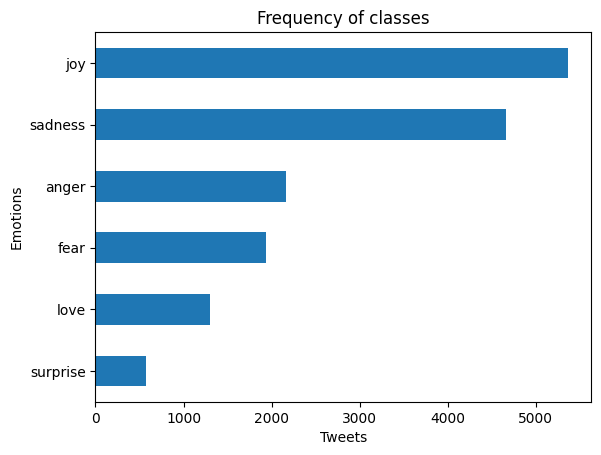

In [10]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.xlabel("Tweets")
plt.ylabel("Emotions")
plt.show()

The dataset is heavily imbalanced; the joy and sadness classes appear frequently, whereas love and surprise are about 5–10 times rarer.


There are several *ways to deal with imbalanced data*, including:
- **Randomly oversample the minority class.**
- **Randomly undersample the majority class.**
- **Gather more labeled data from the underrepresented classes**

Here,we’ll work with the raw, unbalanced class frequencies. Check out the [Imbalanced-learn](https://imbalanced-learn.org/stable/) library. 


**IMPORTANT NOTE: Make sure that you don’t apply sampling methods before creating your train/test splits, or you’ll get plenty of leakage between them!**

`imbalanced-learn` is a Python library that complements `scikit-learn` by providing tools to handle imbalanced datasets. 

In machine learning, an imbalanced dataset occurs when one class significantly outnumbers other classes, leading to biased models. `imbalanced-learn` offers resampling techniques and utilities to address this issue.


**Key Features of `imbalanced-learn`**
1. **Resampling Techniques**:
   - **Oversampling**: Increases the size of the minority class.
     - Example: `RandomOverSampler`, `SMOTE`, `ADASYN`
   - **Undersampling**: Reduces the size of the majority class.
     - Example: `RandomUnderSampler`, `ClusterCentroids`
   - **Combination**: Mixes oversampling and undersampling.
     - Example: `SMOTEENN`, `SMOTETomek`
2. **Integration with scikit-learn**:
   - Compatible with `scikit-learn` pipelines, allowing seamless integration with pre-processing, feature selection, and model training.
3. **Metrics for Imbalanced Data**:
   - Provides metrics like precision, recall, F1 score, and AUC to evaluate performance on imbalanced datasets.
4. **Dataset Sampling**:
   - Functions to check dataset balance and apply sampling strategies.

---

**Key Methods in `imbalanced-learn`**

1. **Oversampling Techniques**:
   - **RandomOverSampler**:
     - Randomly duplicates samples from the minority class.
     - Example:
       ```python
       from imblearn.over_sampling import RandomOverSampler
       ros = RandomOverSampler()
       X_resampled, y_resampled = ros.fit_resample(X, y)
       ```
   - **SMOTE (Synthetic Minority Oversampling Technique)**:
     - Generates synthetic samples for the minority class by interpolating between existing samples.
     - Variants: `BorderlineSMOTE`, `SVMSMOTE`
     - Example:
       ```python
       from imblearn.over_sampling import SMOTE
       smote = SMOTE()
       X_resampled, y_resampled = smote.fit_resample(X, y)
       ```

2. **Undersampling Techniques**:
   - **RandomUnderSampler**:
     - Randomly removes samples from the majority class.
     - Example:
       ```python
       from imblearn.under_sampling import RandomUnderSampler
       rus = RandomUnderSampler()
       X_resampled, y_resampled = rus.fit_resample(X, y)
       ```
   - **ClusterCentroids**:
     - Replaces majority class samples with their centroids.
     - Example:
       ```python
       from imblearn.under_sampling import ClusterCentroids
       cc = ClusterCentroids()
       X_resampled, y_resampled = cc.fit_resample(X, y)
       ```

3. **Combination Techniques**:
   - **SMOTEENN (SMOTE + Edited Nearest Neighbors)**:
     - Applies SMOTE followed by ENN to clean data.
     - Example:
       ```python
       from imblearn.combine import SMOTEENN
       smoteenn = SMOTEENN()
       X_resampled, y_resampled = smoteenn.fit_resample(X, y)
       ```
   - **SMOTETomek**:
     - Combines SMOTE with Tomek links to remove overlapping data points.
     - Example:
       ```python
       from imblearn.combine import SMOTETomek
       smotetomek = SMOTETomek()
       X_resampled, y_resampled = smotetomek.fit_resample(X, y)
       ```

---

**Pipeline Integration**
`imbalanced-learn` integrates smoothly with `scikit-learn` pipelines to handle preprocessing, resampling, and modeling in a single workflow.

Example:
```python
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Example pipeline
pipeline = Pipeline([
    ('smote', SMOTE()),
    ('classifier', RandomForestClassifier())
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
score = pipeline.score(X_test, y_test)
```

---

**Evaluation Metrics for Imbalanced Data**
When dealing with imbalanced datasets, accuracy may not reflect the true model performance. Use these metrics instead:
- **Precision**: True positives / (True positives + False positives)
- **Recall**: True positives / (True positives + False negatives)
- **F1 Score**: Harmonic mean of precision and recall
- **ROC-AUC**: Area under the Receiver Operating Characteristic curve

Example:
```python
from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
```

---

**Common Use Cases**
- Fraud detection
- Medical diagnosis
- Spam filtering
- Rare event prediction

---

**Installation**
To install `imbalanced-learn`:
```bash
pip install imbalanced-learn
```

---

By combining the resampling techniques from `imbalanced-learn` with the power of `scikit-learn`, you can effectively handle imbalanced datasets and improve model performance.

##  How Long Are Our Tweets?

- **Transformer models have a maximum input sequence length that is referred to as the maximum context size.**
-  For applications using DistilBERT, the maximum context size
 is *512* tokens.

Let's get a rough estimate of tweet lengths per emotion by looking at the distribution of words per tweet.

In [11]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df["Words Per Tweet"]

0         4
1        21
2        10
3        18
4         4
         ..
15995    24
15996    20
15997     6
15998    14
15999    15
Name: Words Per Tweet, Length: 16000, dtype: int64

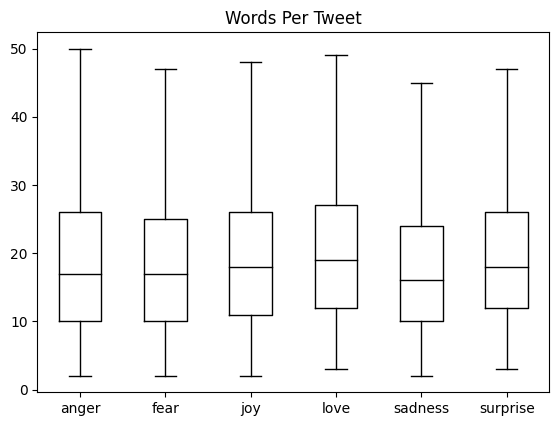

In [12]:
# create a boxplot to represent words per tweet
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

For each emotion, most tweets are around 15 words long and the longest tweets are well below DistilBERT’s maximum context size. Therefore, no need to truncate texts.

Now, let’s also reset the output format of our dataset since we don’t need the DataFrame format anymore.

In [13]:
emotions.reset_format()

# From Text to Tokens
